# Decomposition

In [1]:
suppressMessages(library(fable))

In [2]:
suppressMessages(library(forecast))

In [3]:
suppressMessages(library(tsibble))

In [4]:
suppressMessages(library(tidyverse))

In [5]:
suppressMessages(library(fabletools))

In [6]:
suppressMessages(library(feasts))

In [7]:
suppressMessages(library(lubridate))

In [8]:
suppressMessages(library(scales))

## Calendar Adjustments
- Months will have different numbers of days.
- Months will start at various days of the weeks.
- Calendar effects can lead to distortions that can be systematically adjusted.

In [9]:
fedVolume <- read.csv('data/EFFRVOL.csv')

In [10]:
fedVolume %>% head()

,DATE,EFFRVOL
,<chr>,<chr>
1,2018-10-04,73.0
2,2018-10-05,64.0
3,2018-10-08,.
4,2018-10-09,57.0
5,2018-10-10,64.0
6,2018-10-11,66.0


In [11]:
fedVolumeMonthly <- fedVolume %>%
  filter(EFFRVOL != '.') %>%
  mutate(mdt = floor_date(ymd(DATE),'month')) %>%
  group_by(mdt) %>%
  summarise(Volume=sum(as.numeric(EFFRVOL)), Days=n(), .groups='drop') %>%
  mutate(AverageDaily = Volume/Days) %>%
  as_tsibble(index='mdt') %>%
  filter_index(. ~ "2023 Sep")

In [12]:
fedVolumeMonthly %>% head()

mdt,Volume,Days,AverageDaily
<date>,<dbl>,<int>,<dbl>
2018-10-01,1156,19,60.84211
2018-11-01,1311,20,65.55000
2018-12-01,1368,20,68.40000
2019-01-01,1310,21,62.38095
2019-02-01,1370,19,72.10526
2019-03-01,1593,21,75.85714


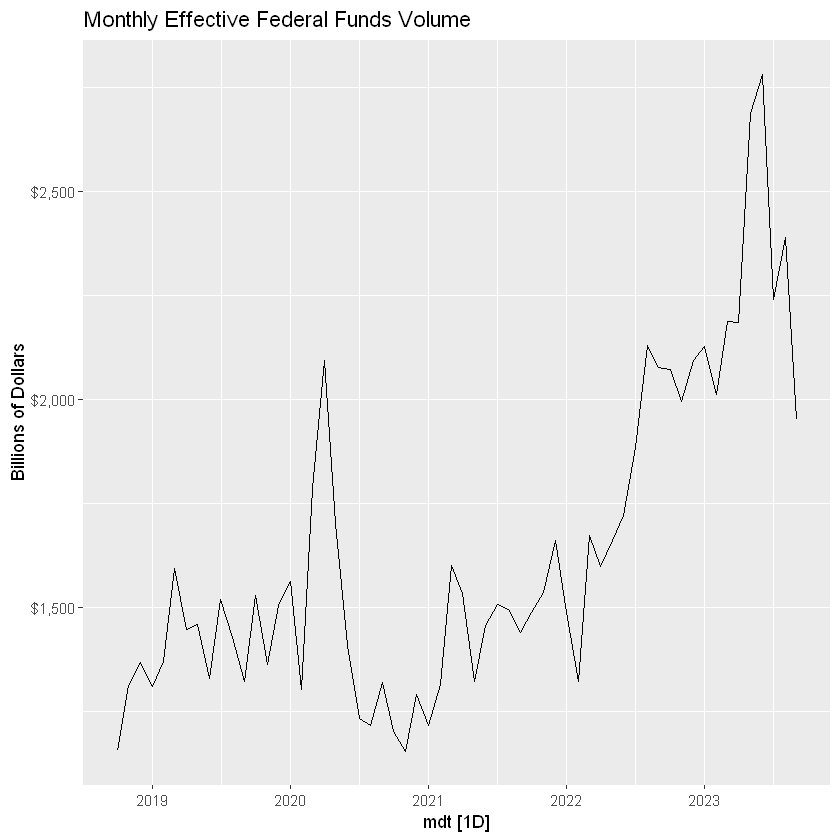

In [13]:
fedVolumeMonthly %>% autoplot(Volume) +
  ggtitle('Monthly Effective Federal Funds Volume') +
  ylab('Billions of Dollars') +
  scale_y_continuous(label=scales::dollar_format())

Note: Volume only occurs on non-Holidays during the week.

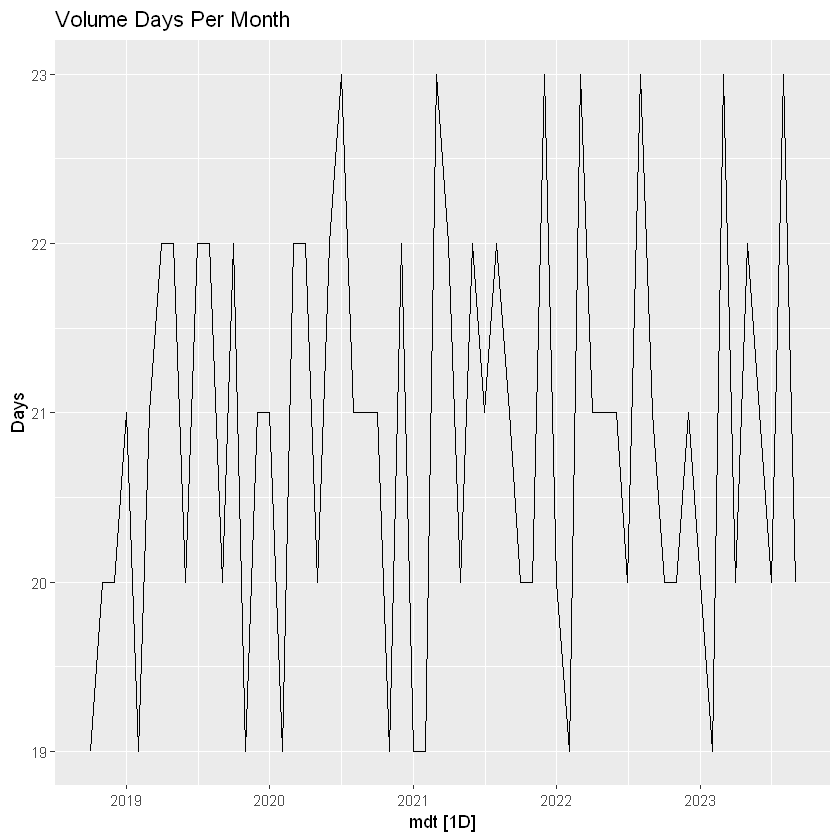

In [14]:
fedVolumeMonthly %>% autoplot(Days) + labs(title='Volume Days Per Month', y='Days')

In [15]:
(23/19 - 1)*100

[1] 21.05263

Note: Varies from 19 to 23 days.

In [16]:
avgDays <- mean(fedVolumeMonthly$Days)

In [17]:
avgDays

[1] 20.88333

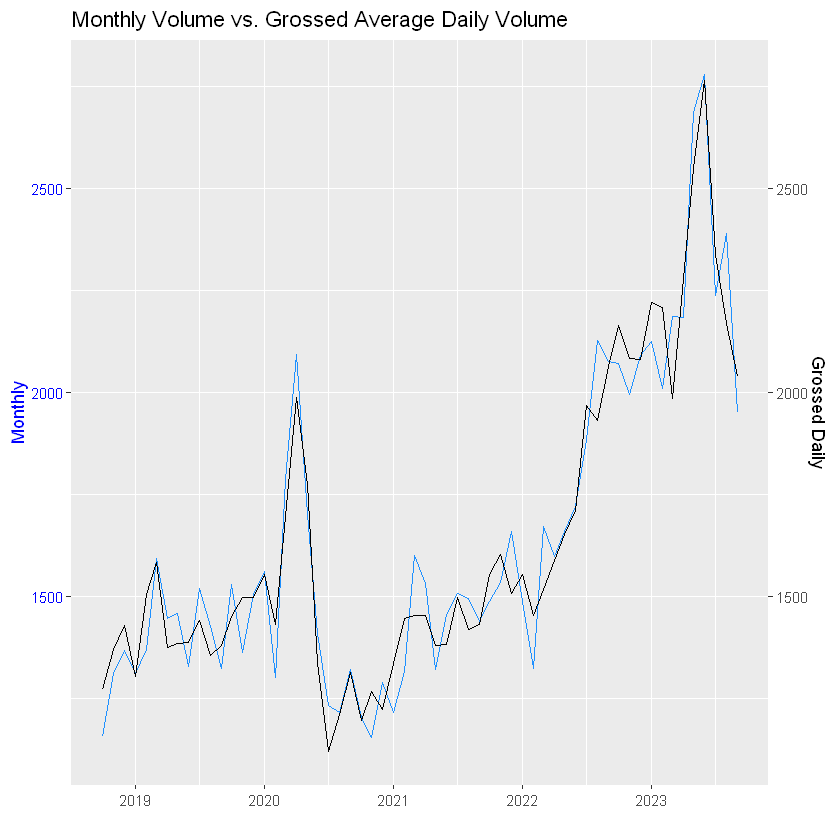

In [18]:
ggplot(fedVolumeMonthly) +
  geom_line(aes(x= mdt, y= Volume), color = 'dodgerblue') +
  geom_line(aes(x= mdt, y = AverageDaily*avgDays), stat = 'identity') + 
  ylab('Monthly') +
  scale_y_continuous(sec.axis = sec_axis(~., name = 'Grossed Daily')) +
  xlab('') +
  ggtitle('Monthly Volume vs. Grossed Average Daily Volume') +
  theme(axis.text.y.left = element_text(colour = "blue"), 
        axis.title.y.left = element_text(colour="blue")
  )

### Compare the variance between the raw and adjusted data
The adjusted data should have a smaller variance.

In [19]:
sd(fedVolumeMonthly$Volume)

[1] 379.7706

In [20]:
sd(fedVolumeMonthly$AverageDaily*avgDays)

[1] 368.1775

Note: The standard deviation has decreased.

## Population Adjustments

In [21]:
gdp <- read.csv('data/gdpc1.csv')

In [22]:
gdp %>% head(1)

,DATE,GDPC1
,<chr>,<dbl>
1,1947-01-01,2182.681


In [23]:
gdp_capita <- read.csv('data/A939RX0Q048SBEA.csv')

In [24]:
gdp_capita %>% head(1)

,DATE,A939RX0Q048SBEA
,<chr>,<dbl>
1,1947-01-01,15248


In [25]:
gdp <- gdp %>% mutate(DATE = as.Date(DATE)) %>% as_tsibble(index=DATE)

In [26]:
gdp_capita <- gdp_capita %>% mutate(DATE = as.Date(DATE)) %>% as_tsibble(index=DATE)

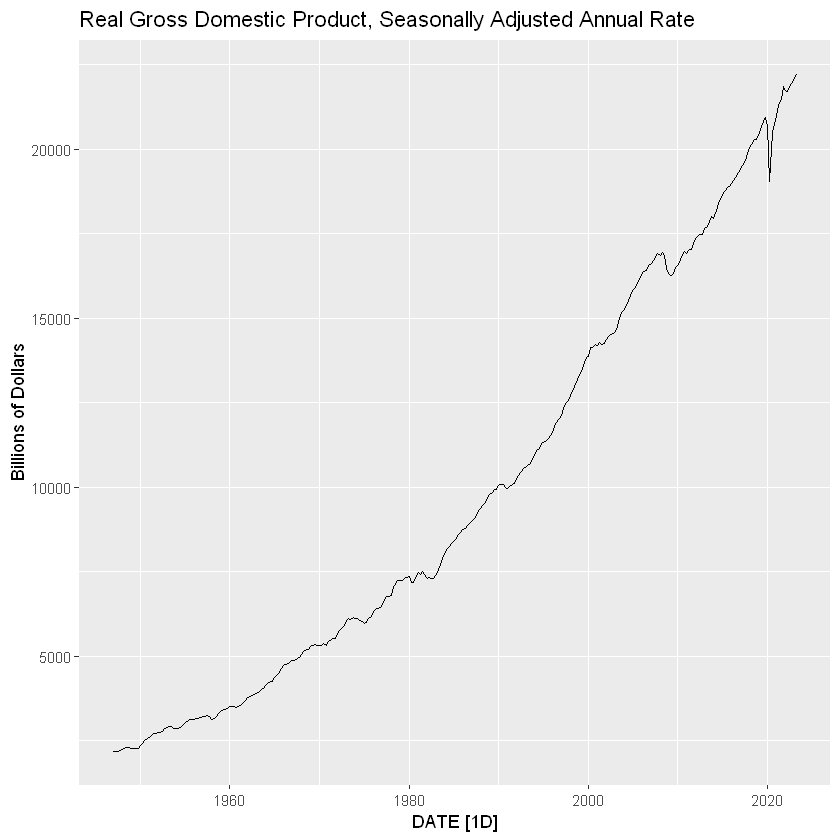

In [27]:
gdp %>% autoplot(GDPC1) + labs(title='Real Gross Domestic Product, Seasonally Adjusted Annual Rate', y='Billions of Dollars')

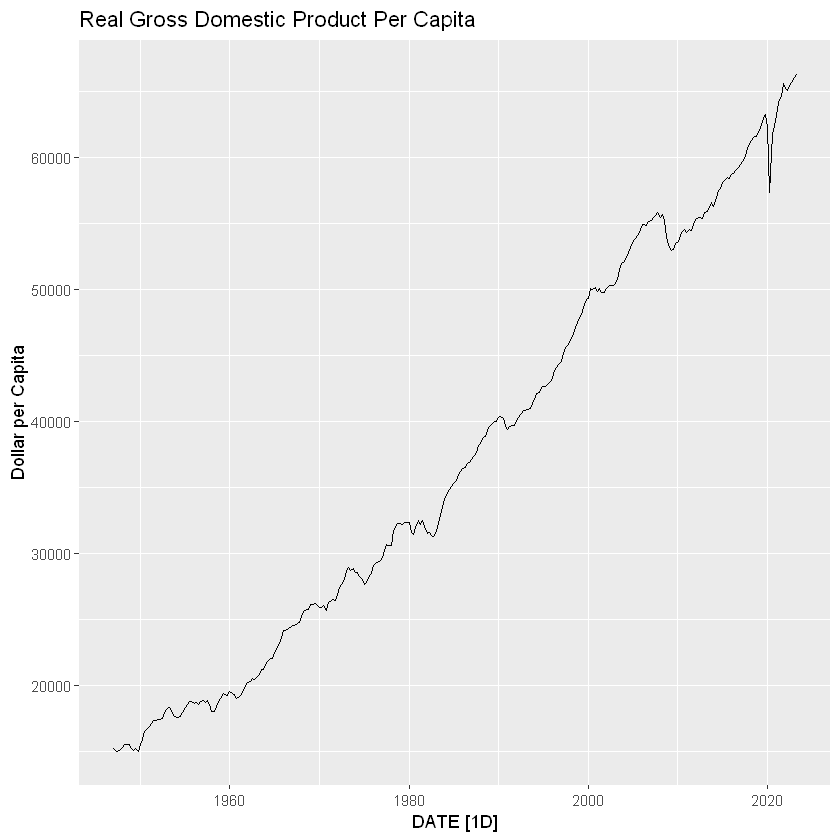

In [28]:
gdp_capita %>% autoplot(A939RX0Q048SBEA) + labs(title='Real Gross Domestic Product Per Capita', y='Dollar per Capita')

## Deflating the Value of Money

In [29]:
cpi <- read.csv('data/CPIAUCSL.csv')

In [30]:
cpi <- cpi %>%
  mutate(mdt = floor_date(ymd(DATE),'month')) %>%
  as_tsibble(index='mdt')

In [31]:
cpi %>% head(1)

DATE,CPIAUCSL,mdt
<chr>,<dbl>,<date>
1947-01-01,21.48,1947-01-01


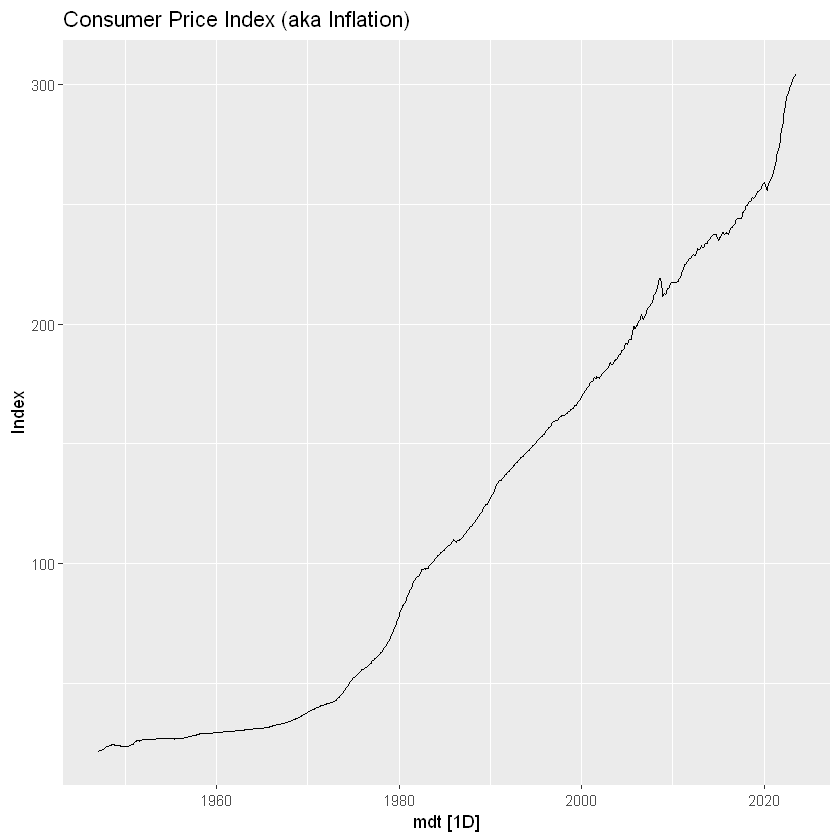

In [32]:
cpi %>% autoplot(CPIAUCSL) + labs(title='Consumer Price Index (aka Inflation)', y='Index')

In [33]:
gas <- read.csv('data/GASREGW.csv')

In [34]:
gas %>% head()

,DATE,GASREGW
,<chr>,<chr>
1,1990-08-20,1.191
2,1990-08-27,1.245
3,1990-09-03,1.242
4,1990-09-10,1.252
5,1990-09-17,1.266
6,1990-09-24,1.272


In [35]:
gas <- gas %>%
    filter(GASREGW != ".") %>%
    mutate(gas_price = as.numeric(GASREGW)) %>%
    select(-GASREGW) %>%
    mutate(DATE = ymd(DATE)) %>%
    as_tsibble(index='DATE')

In [36]:
gas %>% head()

DATE,gas_price
<date>,<dbl>
1990-08-20,1.191
1990-08-27,1.245
1990-09-03,1.242
1990-09-10,1.252
1990-09-17,1.266
1990-09-24,1.272


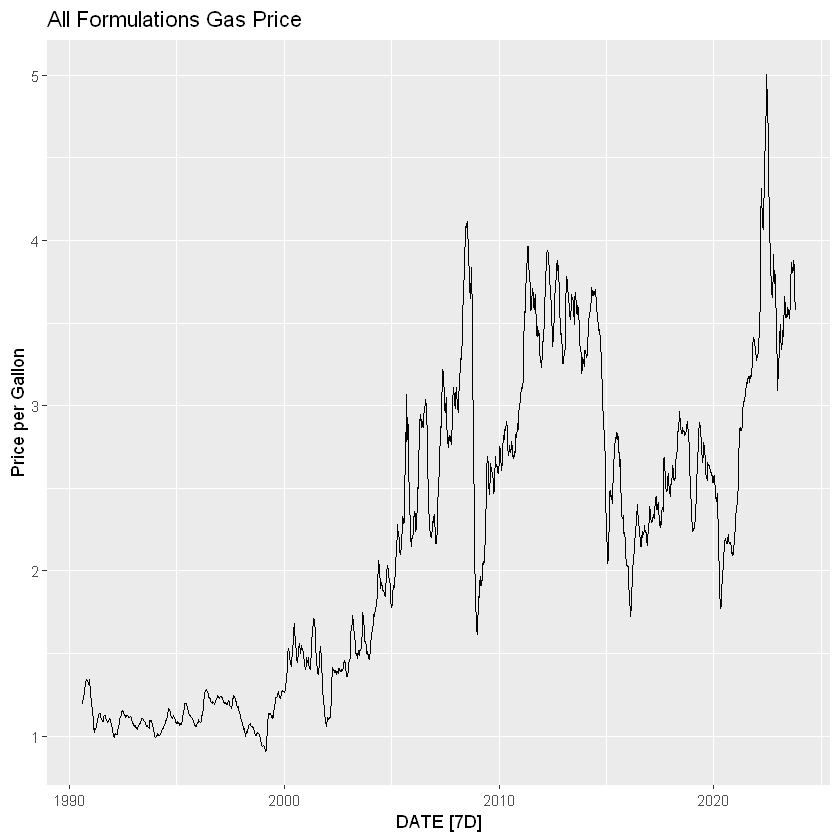

In [37]:
gas %>% autoplot(gas_price) + labs(title='All Formulations Gas Price', y='Price per Gallon')

$Real_t = Nominal_t * Index_t / Index_0$

In [38]:
cpi_m <- cpi %>% as_tsibble(index=mdt) %>% select(-DATE)

In [39]:
monthly_gas <- gas %>%
    mutate(mdt = floor_date(DATE, 'month')) %>%
    arrange(mdt, desc(DATE)) %>%
    group_by(mdt) %>%
    filter(row_number()==1) %>%
    ungroup() %>%
    arrange(mdt) %>% as_tsibble(index=mdt) %>%
    select(-DATE) %>%
    left_join(cpi_m) %>%
    rename(cpi = CPIAUCSL) %>%
    filter(!is.na(gas_price),!is.na(cpi)) %>%
    mutate(first_cpi = first(cpi)) %>%
    mutate(real_price = gas_price / cpi * first_cpi)

Warning message:
"Current temporal ordering may yield unexpected results.
ℹ Suggest to sort by ``, `DATE` first."
Warning message:
"Current temporal ordering may yield unexpected results.
ℹ Suggest to sort by ``, `DATE` first."
Joining with `by = join_by(mdt)`


In [40]:
monthly_gas %>% head()

gas_price,mdt,cpi,first_cpi,real_price
<dbl>,<date>,<dbl>,<dbl>,<dbl>
1.245,1990-08-01,131.6,131.6,1.245000
1.272,1990-09-01,132.5,131.6,1.263360
1.339,1990-10-01,133.4,131.6,1.320933
1.311,1990-11-01,133.7,131.6,1.290408
1.341,1990-12-01,134.2,131.6,1.315019
1.168,1991-01-01,134.7,131.6,1.141120


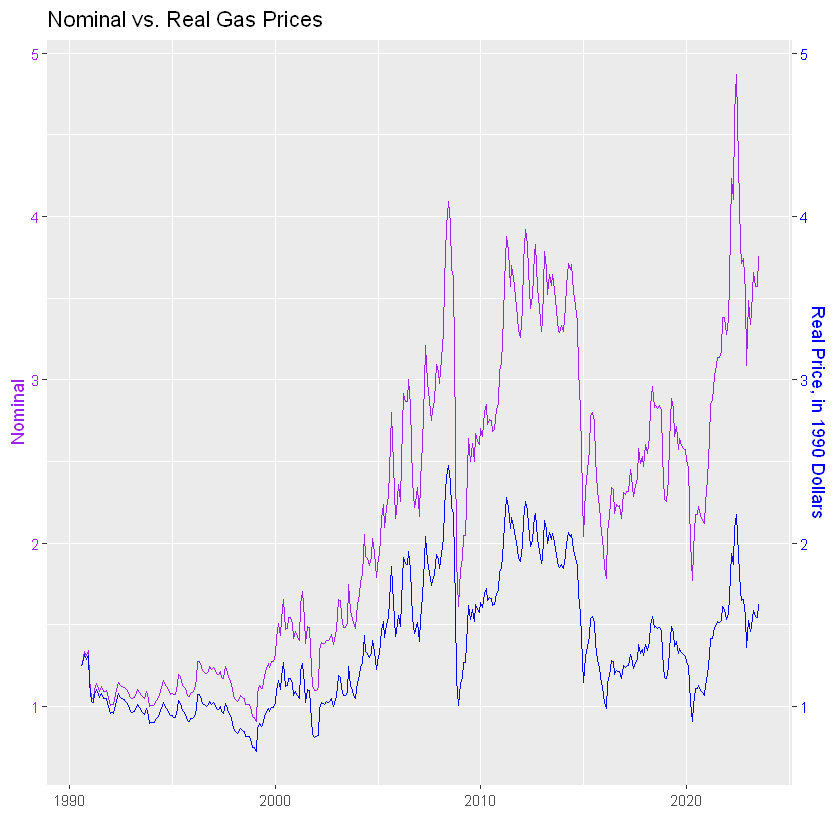

In [41]:
ggplot(monthly_gas) +
geom_line(aes(x=mdt, y=gas_price),color='purple') +
geom_line(aes(x=mdt, y=real_price),color='blue') +
scale_y_continuous(sec.axis = sec_axis(~., name = 'Real Price, in 1990 Dollars')) +
xlab('') +
ylab('Nominal') + 
ggtitle('Nominal vs. Real Gas Prices') +
theme(axis.text.y.left = element_text(colour = "purple"), 
    axis.title.y.left = element_text(colour="purple"),
    axis.text.y.right = element_text(colour = "blue"), 
    axis.title.y.right = element_text(colour="blue") 
)

## Mathematical Transformations and Box-Cox


In [42]:
suppressMessages(library(fpp3))

In [43]:
suppressMessages(library(gridExtra))

Basic Mathematical

In [44]:
food <- aus_retail |>
filter(Industry == "Food retailing") |>
summarise(Turnover = sum(Turnover))

In [45]:
food %>% head()

Month,Turnover
<mth>,<dbl>
1982 Apr,1147.4
1982 May,1135.2
1982 Jun,1143.8
1982 Jul,1189.0
1982 Aug,1136.2
1982 Sep,1172.2


In [46]:
f1 <- food %>% autoplot(Turnover)

In [47]:
f2 <- food |> autoplot(sqrt(Turnover)) +
labs(y = "Square root turnover")

In [48]:
f3 <- food |> mutate(Turnover3c = Turnover^(1/3)) |> autoplot(Turnover3c) +
labs(y = "Cube root turnover")

In [49]:
f4 <- food |> autoplot(log(Turnover)) +
labs(y = "Log turnover")

In [50]:
g <- arrangeGrob(f1, f2, f3, f4, ncol=2)

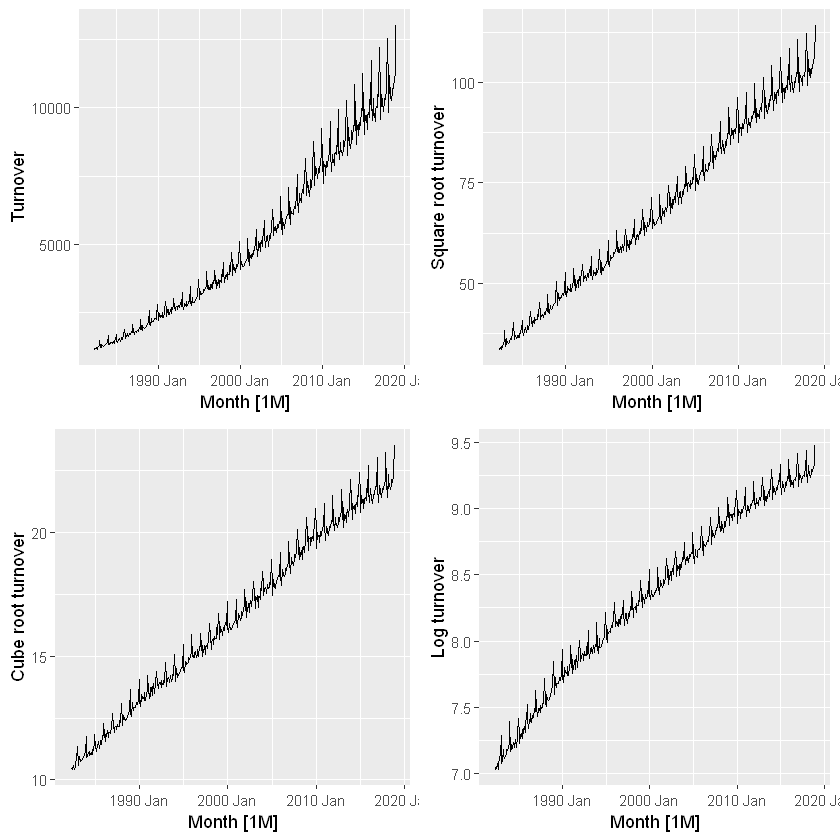

In [51]:
g %>% plot()

Box-Cox

In [52]:
b1 <- food %>% autoplot(Turnover) + ggtitle('Base Series') + labs(y='Turnover')

In [53]:
b2 <- food |> autoplot(box_cox(Turnover, 0)) + ggtitle('Lambda = 0') +
labs(y = "Turnover")

In [54]:
b3 <- food |> autoplot(box_cox(Turnover, 0.5)) + ggtitle('Lambda = 0.5') +
labs(y = "Turnover")

In [55]:
b4 <- food |> autoplot(box_cox(Turnover, 0.9)) + ggtitle('Lambda = 0.9') +
labs(y = "Turnover")

In [56]:
gf <- arrangeGrob(b1, b2, b3, b4, ncol=2)

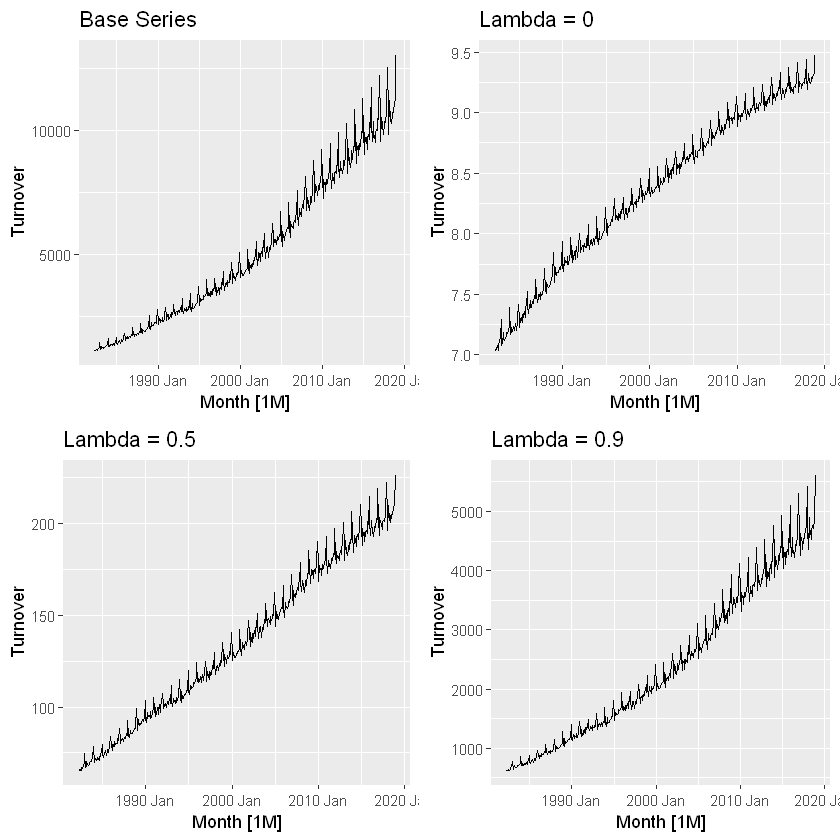

In [57]:
gf %>% plot()

## Additive vs. Multiplicative

In [58]:
unrate <- read.csv('data/unratensa.csv')

In [59]:
unrate <- unrate %>% mutate(DATE = as.Date(DATE)) %>% as_tsibble(index=DATE)
unrate %>% head()

DATE,UNRATENSA
<date>,<dbl>
1948-01-01,4.0
1948-02-01,4.7
1948-03-01,4.5
1948-04-01,4.0
1948-05-01,3.4
1948-06-01,3.9


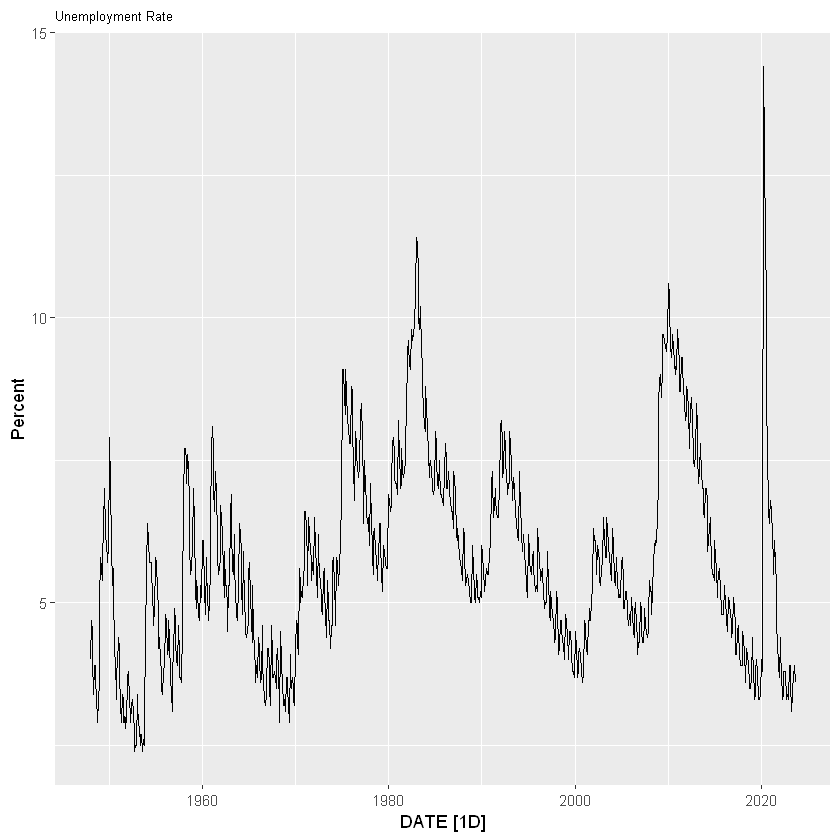

In [60]:
unrate %>% autoplot(UNRATENSA) + ggtitle('Unemployment Rate') + ylab('Percent') +
theme(plot.title = element_text(size=8))

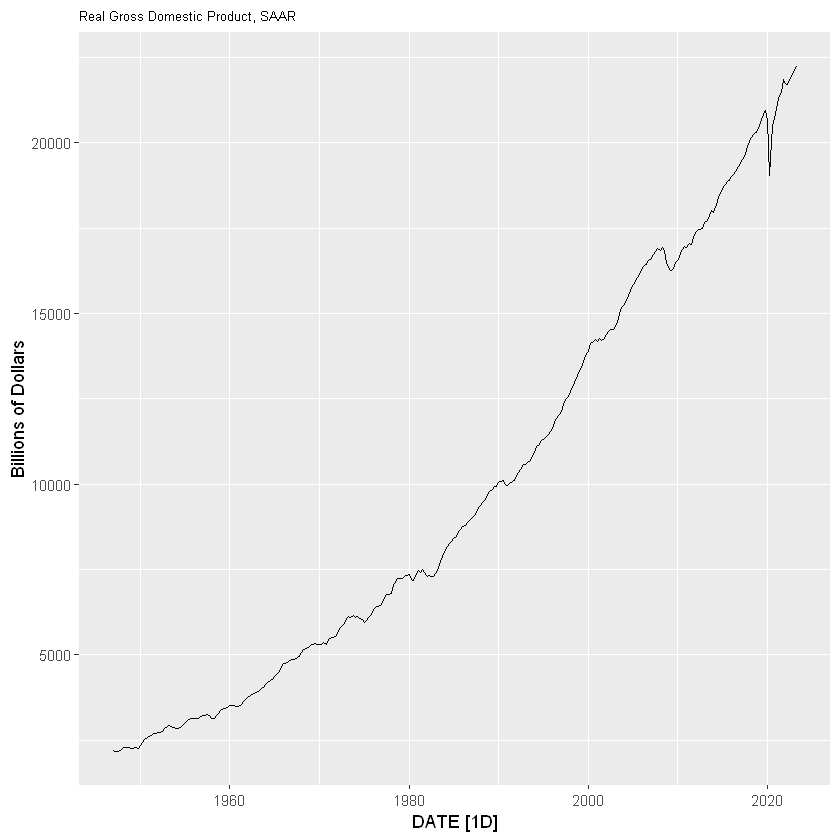

In [61]:
gdp %>% autoplot(GDPC1) + ylab('Billions of Dollars') + ggtitle('Real Gross Domestic Product, SAAR') +
theme(plot.title = element_text(size=8))

## Moving Averages

In [62]:
data("AirPassengers")

In [63]:
ap <- AirPassengers %>% as_tsibble()

In [64]:
names(ap) <- c('Month', 'Passengers')

In [65]:
ap %>% head()

Month,Passengers
<mth>,<dbl>
1949 Jan,112
1949 Feb,118
1949 Mar,132
1949 Apr,129
1949 May,121
1949 Jun,135


In [66]:
apma <- ap %>%
    mutate(`5-MA` = slider::slide_dbl(Passengers, mean, .before=2, .after=2, .complete=TRUE)) %>%
    mutate(`12-MA` = slider::slide_dbl(Passengers, mean, .before=6, .after=5, .complete=TRUE)) %>%
    mutate(`25-MA` = slider::slide_dbl(Passengers, mean, .before=12, .after=12, .complete=TRUE))

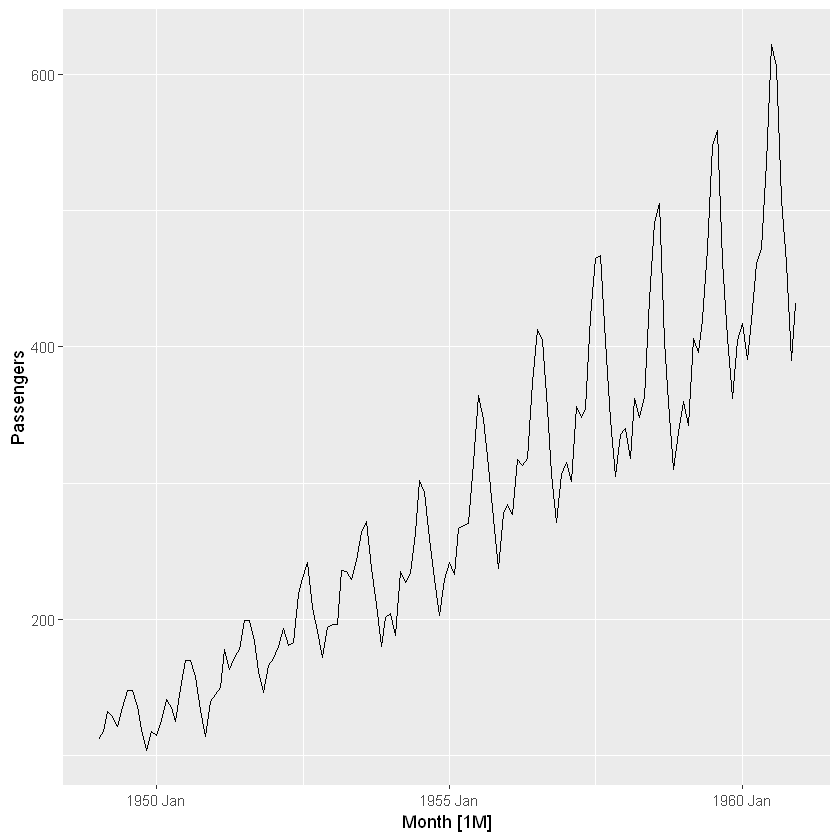

In [67]:
apma %>% autoplot(Passengers)

Warning message:
"Removed 4 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 11 rows containing missing values (`geom_line()`)."


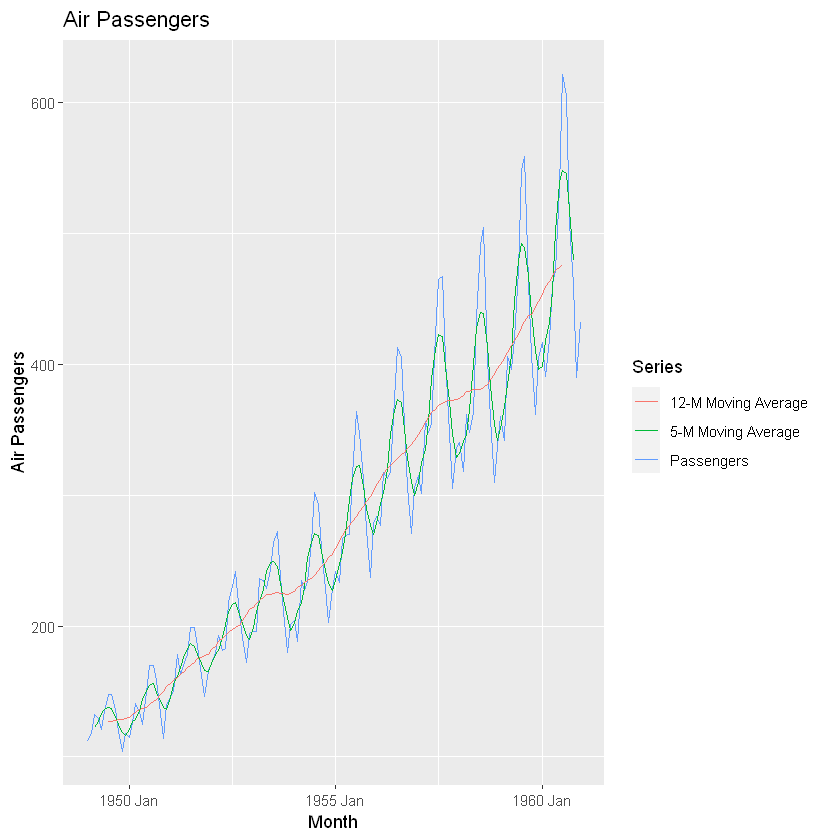

In [68]:
ggplot() +
geom_line(data=apma, aes(x=Month, y=Passengers, colour = "Passengers")) +
geom_line(data=apma, aes(x=Month, y=`5-MA`, colour = "5-M Moving Average")) +
geom_line(data=apma, aes(x=Month, y=`12-MA`, colour = "12-M Moving Average")) +
labs(y="Air Passengers", title="Air Passengers") +
guides(colour = guide_legend(title='Series'))

In [69]:
f1 <- apma %>% autoplot(Passengers)

In [70]:
f2 <- apma %>% autoplot(`5-MA`)

In [71]:
f3 <- apma %>% autoplot(`12-MA`)

In [72]:
f4 <- apma %>% autoplot(`25-MA`)

Warning message:
"Removed 4 rows containing missing values (`geom_line()`)."


Warning message:
"Removed 11 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 24 rows containing missing values (`geom_line()`)."


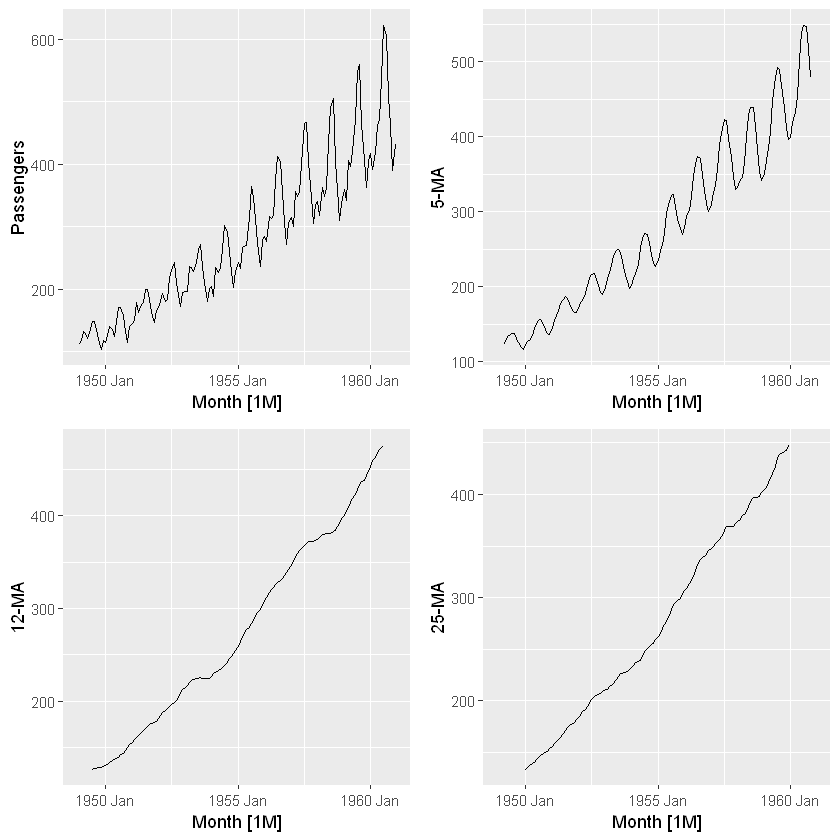

In [73]:
arrangeGrob(f1, f2, f3, f4, ncol=2) %>% plot()

### Moving Average of Moving Averages

In [74]:
apma <- apma %>%
    mutate(`2x12-MA` = slider::slide_dbl(`12-MA`, mean, .before=1, .after=0, .complete=TRUE))

Warning message:
"Removed 11 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 12 rows containing missing values (`geom_line()`)."


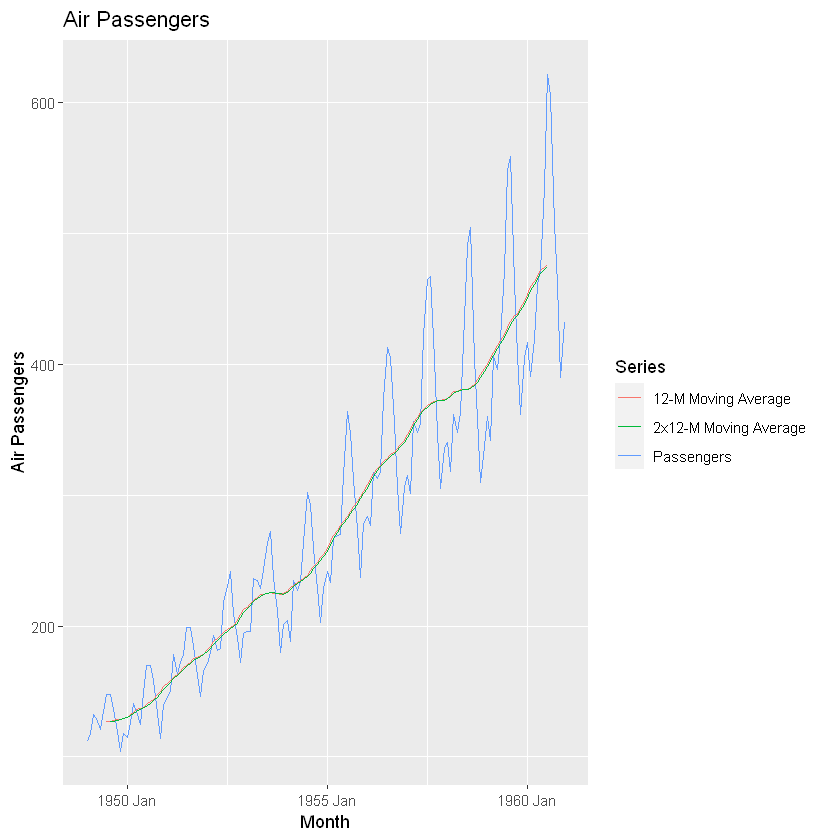

In [75]:
ggplot() +
geom_line(data=apma, aes(x=Month, y=Passengers, colour = "Passengers")) +
geom_line(data=apma, aes(x=Month, y=`12-MA`, colour = "12-M Moving Average")) +
geom_line(data=apma, aes(x=Month, y=`2x12-MA`, colour = "2x12-M Moving Average")) +
labs(y="Air Passengers", title="Air Passengers") +
guides(colour = guide_legend(title='Series'))

In [76]:
apma <- apma %>%
    mutate(Chg = difference(log(Passengers))) %>%
    mutate(`12-MA Chg` = slider::slide_dbl(Chg, mean, .before=6, .after=5, .complete=TRUE)) %>%
    mutate(`2x12-MA Chg` = slider::slide_dbl(`12-MA Chg`, mean, .before=1, .after=0, .complete=TRUE))

Warning message:
"Removed 1 row containing missing values (`geom_line()`)."
Warning message:
"Removed 12 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 13 rows containing missing values (`geom_line()`)."


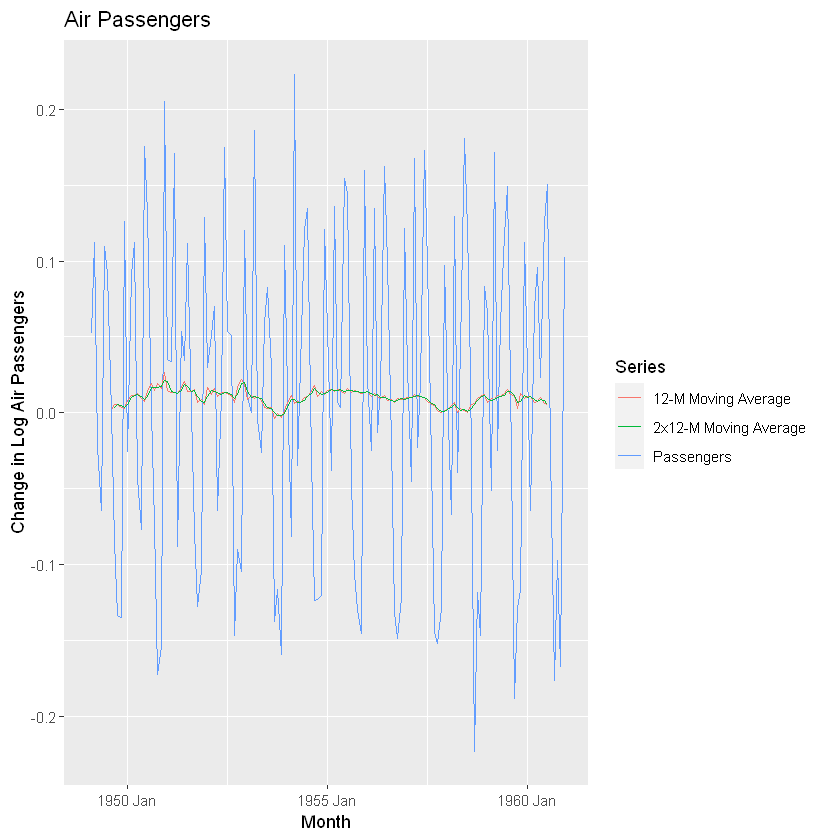

In [77]:
ggplot() +
geom_line(data=apma, aes(x=Month, y=Chg, colour = "Passengers")) +
geom_line(data=apma, aes(x=Month, y=`12-MA Chg`, colour = "12-M Moving Average")) +
geom_line(data=apma, aes(x=Month, y=`2x12-MA Chg`, colour = "2x12-M Moving Average")) +
labs(y="Change in Log Air Passengers", title="Air Passengers") +
guides(colour = guide_legend(title='Series'))

## Classical Decomposition

In [78]:
ap_cl <- ap %>% model(stl = classical_decomposition(Passengers, type='multiplicative'))

Warning message:
"Removed 6 rows containing missing values (`geom_line()`)."


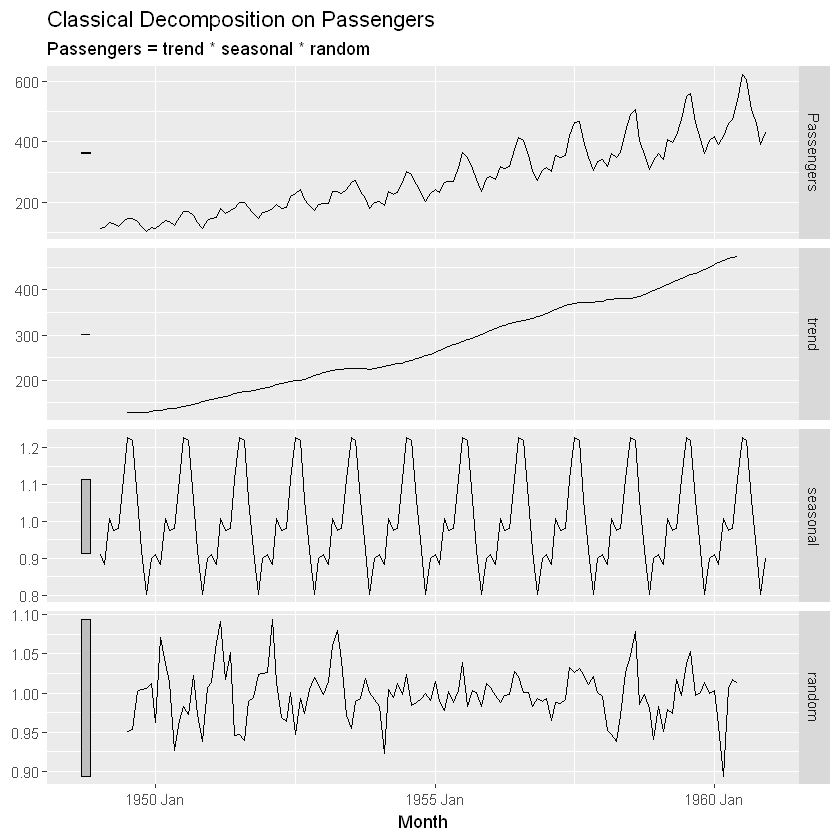

In [79]:
components(ap_cl) |> autoplot() + ggtitle('Classical Decomposition on Passengers')

In [80]:
ap_cl <- ap %>% model(stl = classical_decomposition(log(Passengers), type='additive'))

Warning message:
"Removed 6 rows containing missing values (`geom_line()`)."


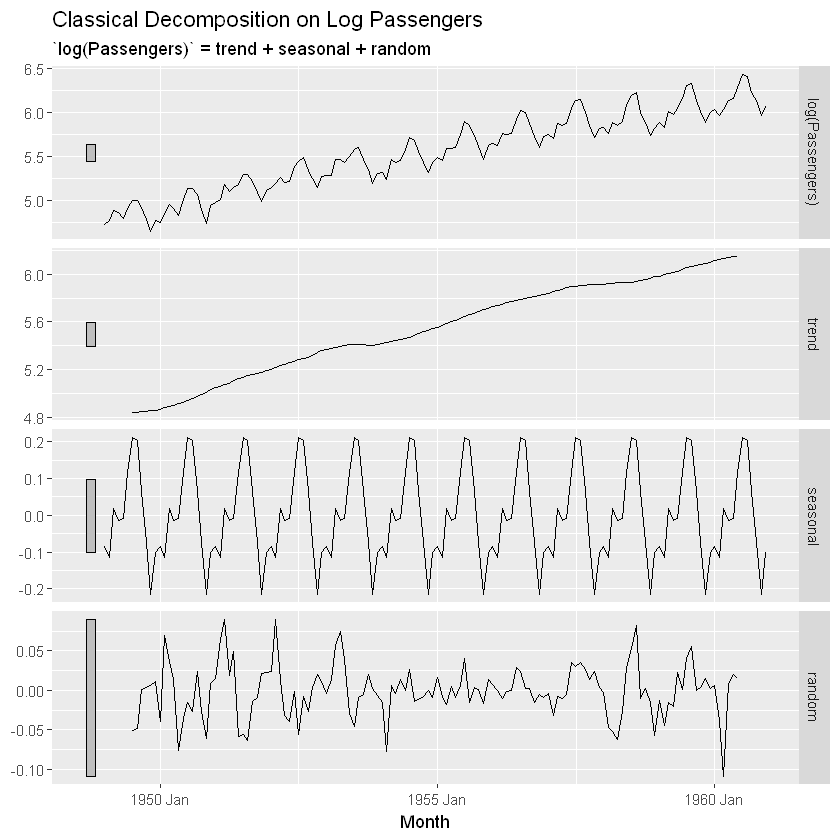

In [81]:
components(ap_cl) |> autoplot() + ggtitle('Classical Decomposition on Log Passengers')

In [82]:
lap_cl <- ap %>% mutate(logchg = difference(log(Passengers))) %>% model(stl = classical_decomposition(logchg))

Warning message:
"Removed 7 rows containing missing values (`geom_line()`)."


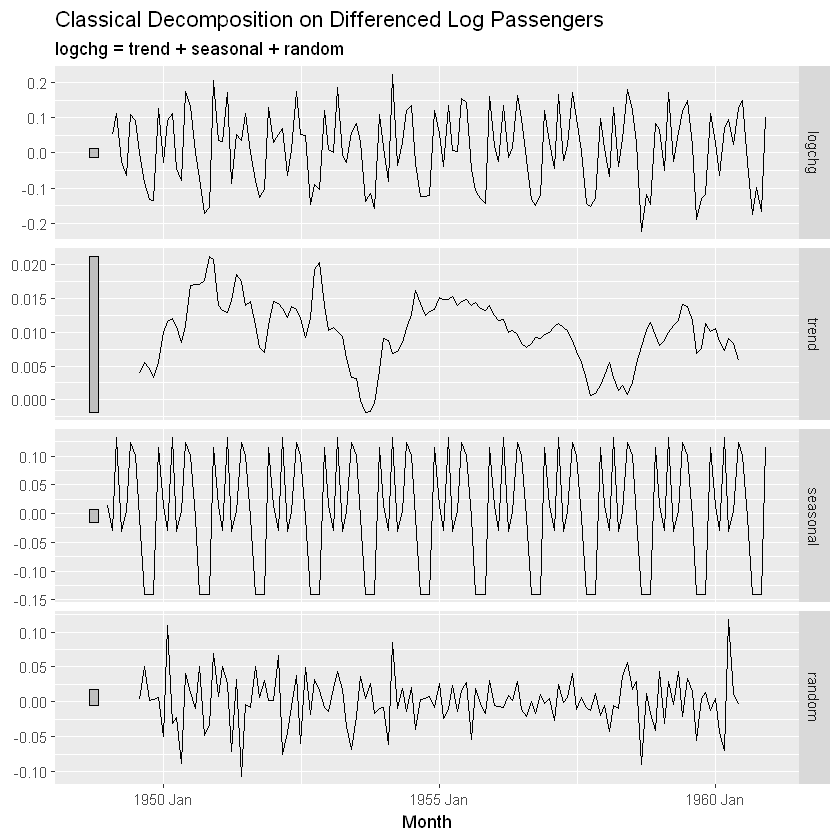

In [83]:
components(lap_cl) |> autoplot(logchg) + ggtitle('Classical Decomposition on Differenced Log Passengers')

## STL

In [84]:
ap_dc <- ap %>% model(stl = STL(Passengers))

In [85]:
ap_dc

stl
<model>
<STL>


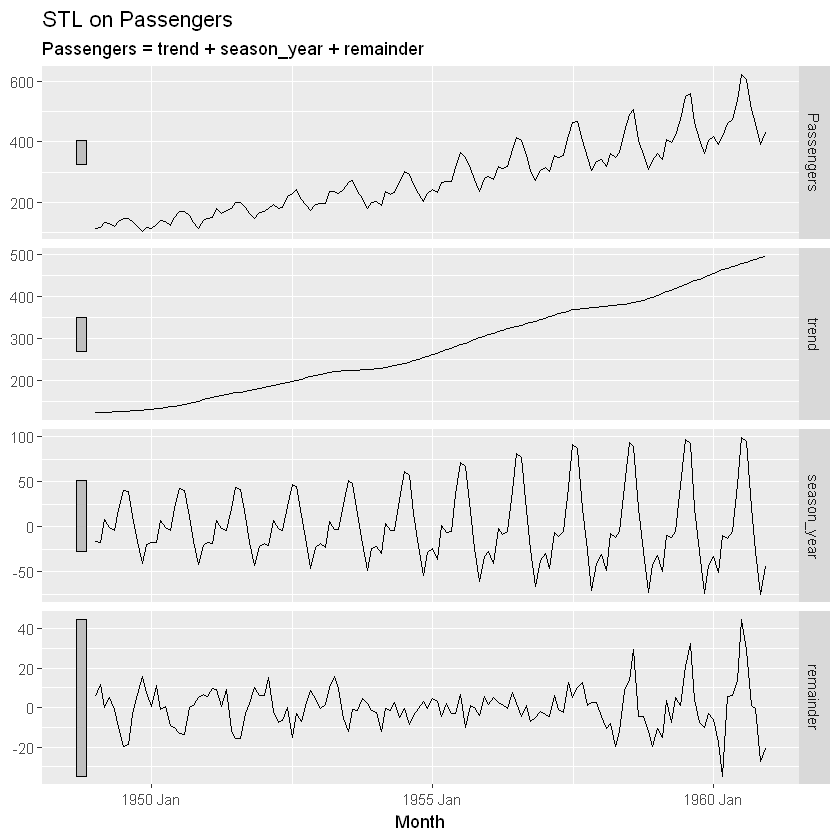

In [86]:
components(ap_dc) |> autoplot() + ggtitle('STL on Passengers')

In [87]:
logap_dc <- ap %>% model(stl = STL(log(Passengers)))

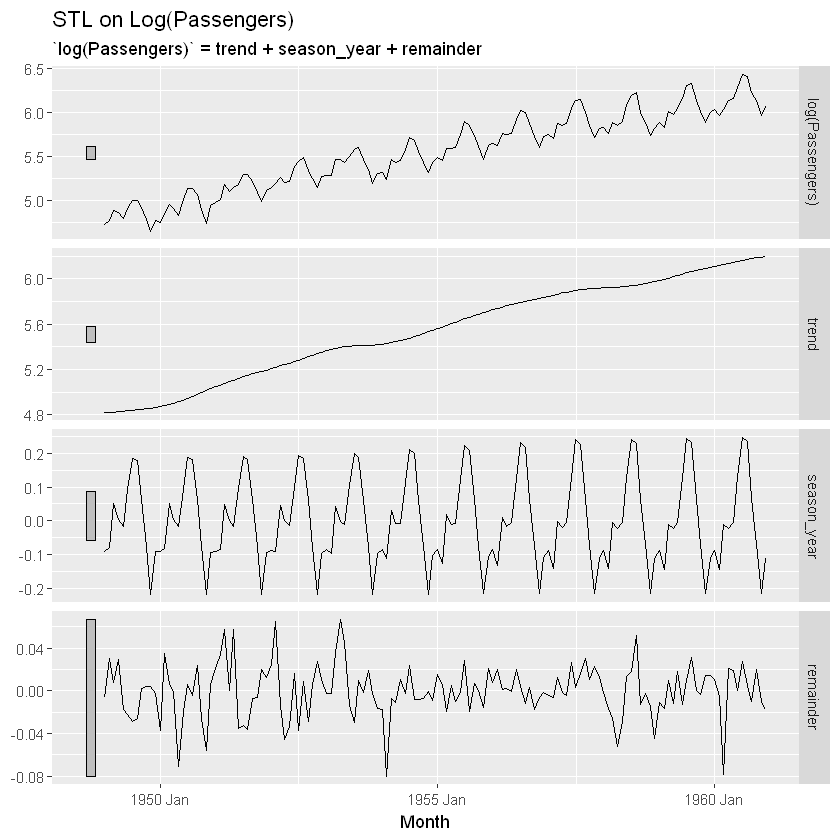

In [88]:
components(logap_dc) |> autoplot() + ggtitle('STL on Log(Passengers)')

In [89]:
ap_dc_comp <- components(ap_dc) |> as_tsibble()

In [90]:
log_dc_comp <- components(logap_dc) |> as_tsibble() %>% mutate(exp_seasadj = exp(season_adjust))

In [91]:
log_dc_comp %>% head()

.model,Month,log(Passengers),trend,season_year,remainder,season_adjust,exp_seasadj
<chr>,<mth>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
stl,1949 Jan,4.718499,4.815459,-0.090671174,-0.006289393,4.809170,122.6298
stl,1949 Feb,4.770685,4.819288,-0.078777840,0.030174492,4.849462,127.6717
stl,1949 Mar,4.882802,4.823117,0.051855657,0.007829759,4.830946,125.3295
stl,1949 Apr,4.859812,4.826945,0.003540479,0.029326884,4.856272,128.5441
stl,1949 May,4.795791,4.831197,-0.017497174,-0.017909003,4.813288,123.1358
stl,1949 Jun,4.905275,4.835448,0.092283594,-0.022457218,4.812991,123.0993


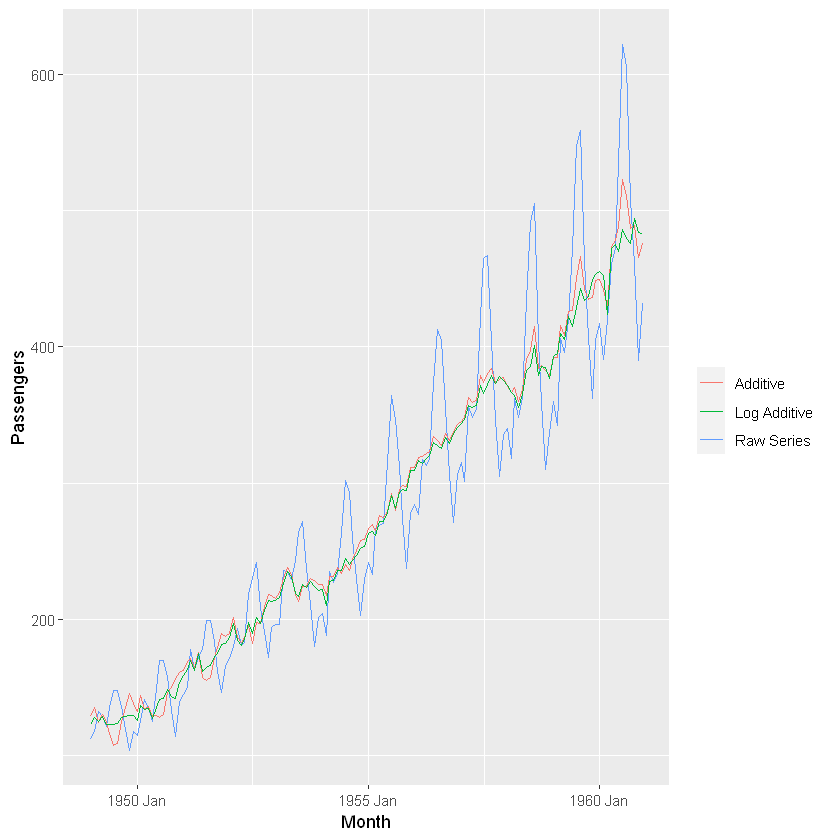

In [92]:
ggplot() +
    geom_line(data=ap, aes(x=Month, y=Passengers, colour = "Raw Series")) +
    geom_line(data=ap_dc_comp, aes(x=Month, y=season_adjust, colour = "Additive")) +
    geom_line(data=log_dc_comp, aes(x=Month, y=exp_seasadj, colour ='Log Additive')) +
    guides(colour=guide_legend(title=""))

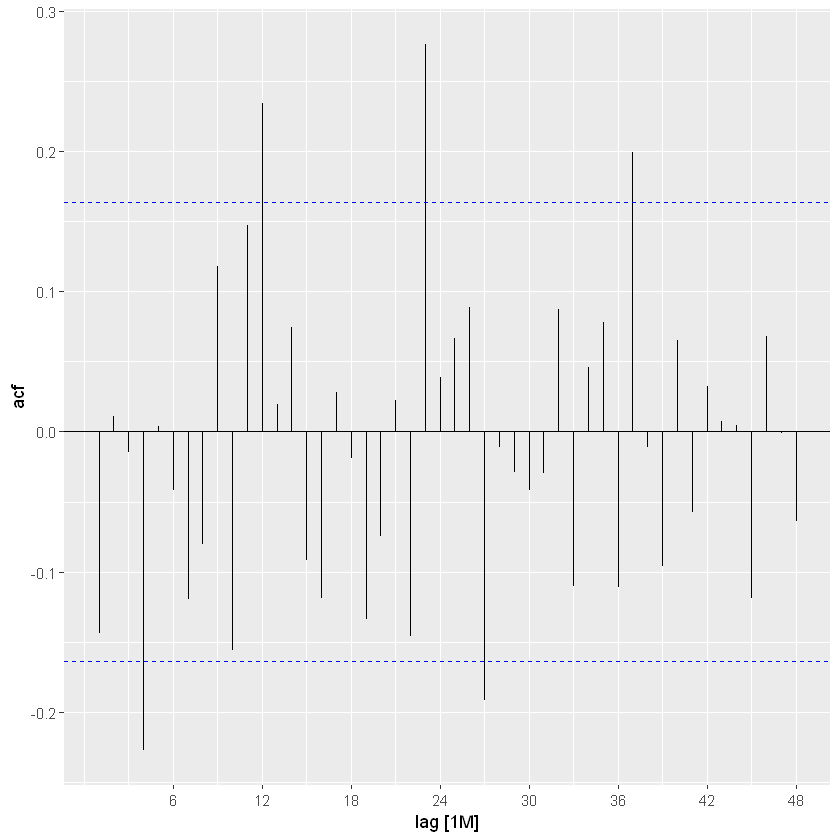

In [93]:
ap_dc_comp %>% ACF(diff(season_adjust), lag_max = 48) %>% autoplot()

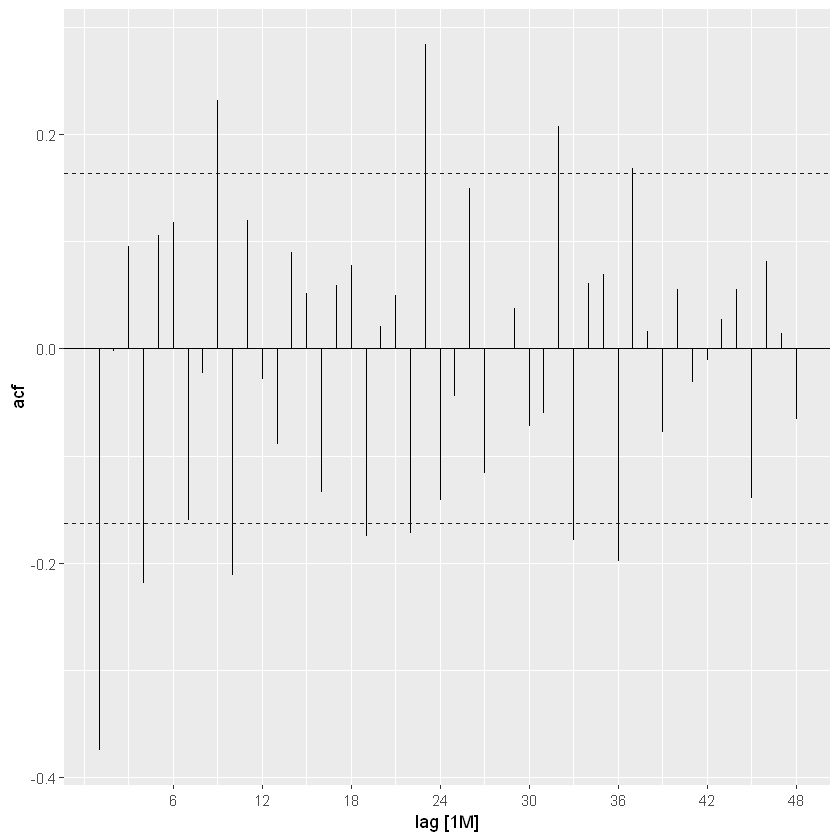

In [94]:
log_dc_comp %>% ACF(diff(exp_seasadj), lag_max=48) %>% autoplot()

## Seasonal Adjustment - a Different Approach to Seasonality

In [95]:
suppressMessages(library(seasonal))

In [96]:
fit <- ap %>%
  model(X_13ARIMA_SEATS(Passengers))

In [97]:
seasonal_comp <- components(fit)

In [98]:
seasonal_adj <- seasonal_comp %>% select(-`.model`)

In [99]:
linear_trend_model_sa <- seasonal_adj %>% model(TSLM(season_adjust ~ trend()))

In [100]:
report(linear_trend_model_sa)

Series: season_adjust 
Model: TSLM 

Residuals:
      Min        1Q    Median        3Q       Max 
-36.47425  -8.94744   0.00392   8.49079  31.56180 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 88.50970    2.34508   37.74   <2e-16 ***
trend()      2.64183    0.02806   94.15   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 14 on 142 degrees of freedom
Multiple R-squared: 0.9842,	Adjusted R-squared: 0.9841
F-statistic:  8864 on 1 and 142 DF, p-value: < 2.22e-16


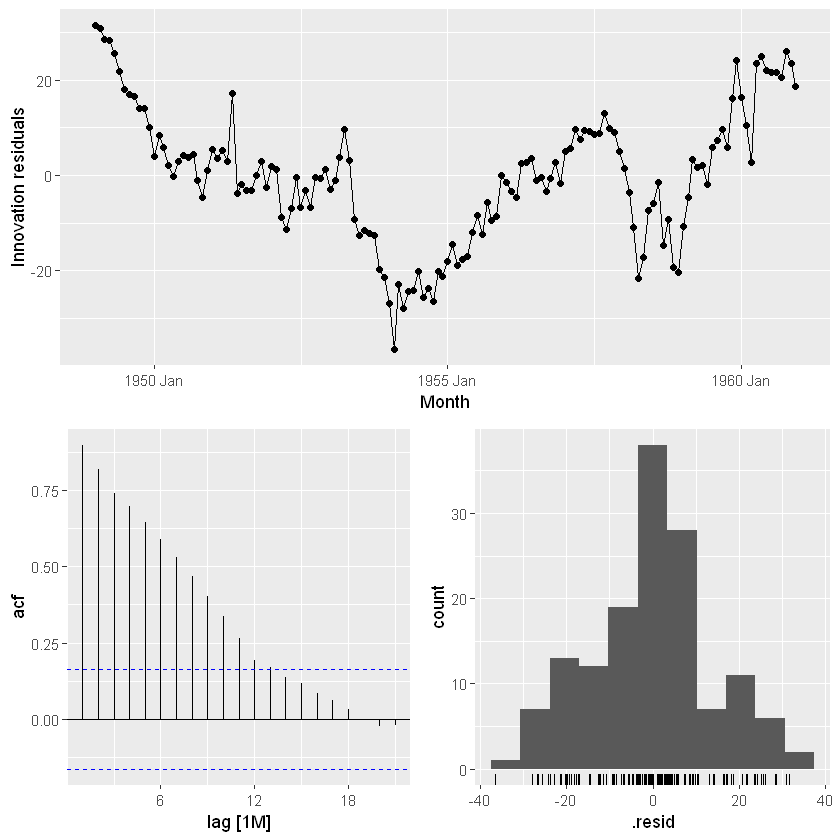

In [101]:
linear_trend_model_sa %>% gg_tsresiduals()

In [102]:
sa_trend <- fitted(linear_trend_model_sa)$.fitted

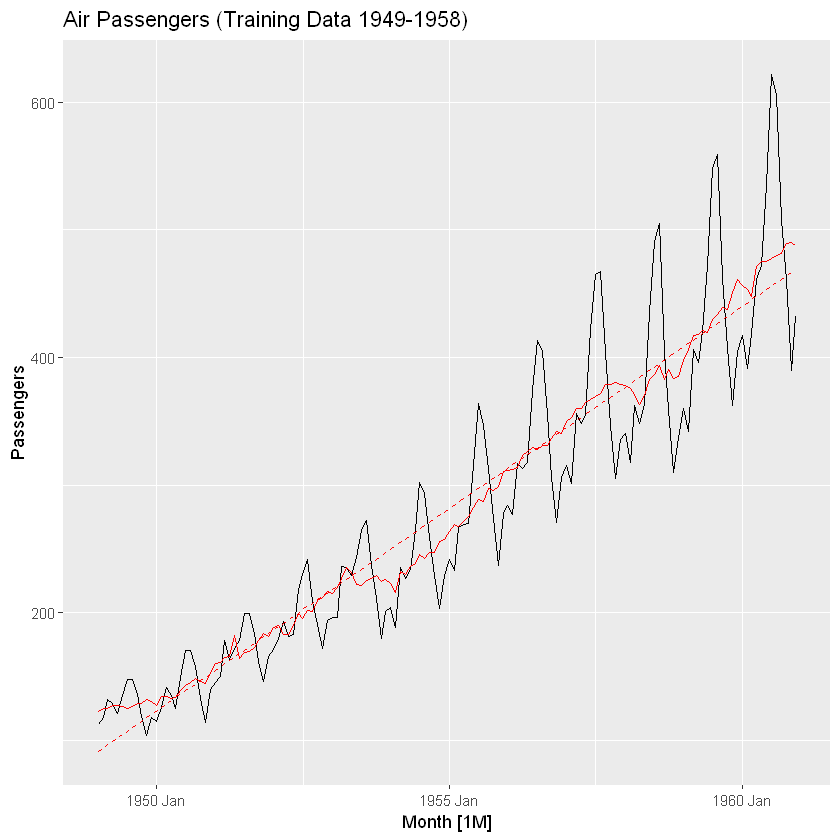

In [103]:
autoplot(ap, Passengers) + ggtitle('Air Passengers (Training Data 1949-1958)') +
  autolayer(seasonal_adj, season_adjust, col='red') +
  geom_line(aes(y=sa_trend), color='red', linetype='dashed')

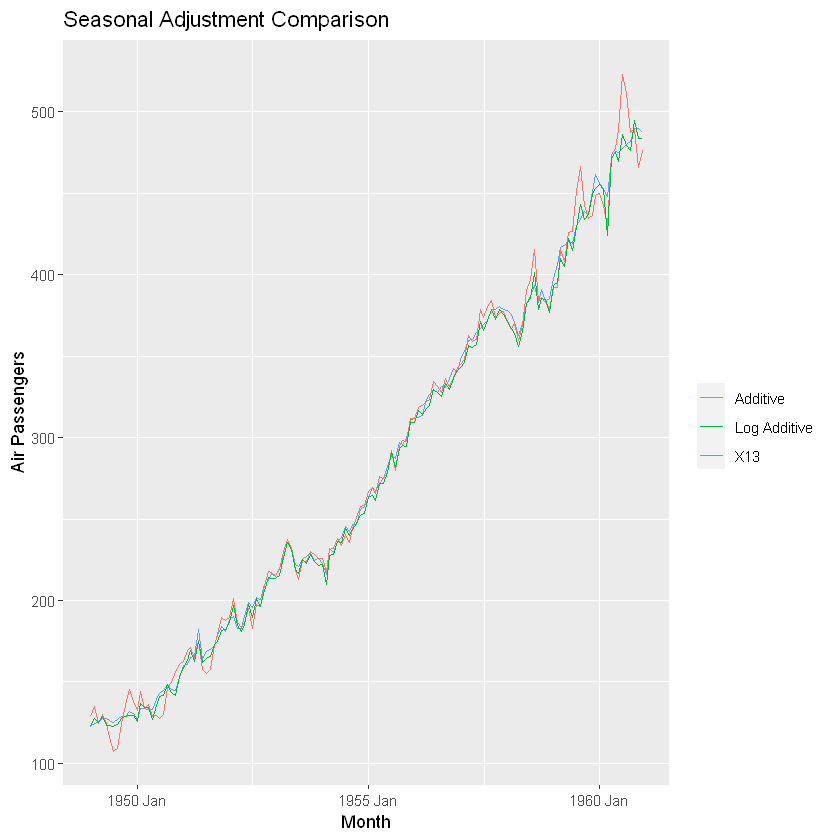

In [104]:
ggplot() +
    geom_line(data=seasonal_adj, aes(Month,season_adjust, colour='X13'))+
    geom_line(data=ap_dc_comp, aes(x=Month, y=season_adjust, colour = "Additive")) +
    geom_line(data=log_dc_comp, aes(x=Month, y=exp_seasadj, colour ='Log Additive')) +
    ylab('Air Passengers') +
    guides(colour=guide_legend(title="")) +
    ggtitle('Seasonal Adjustment Comparison')

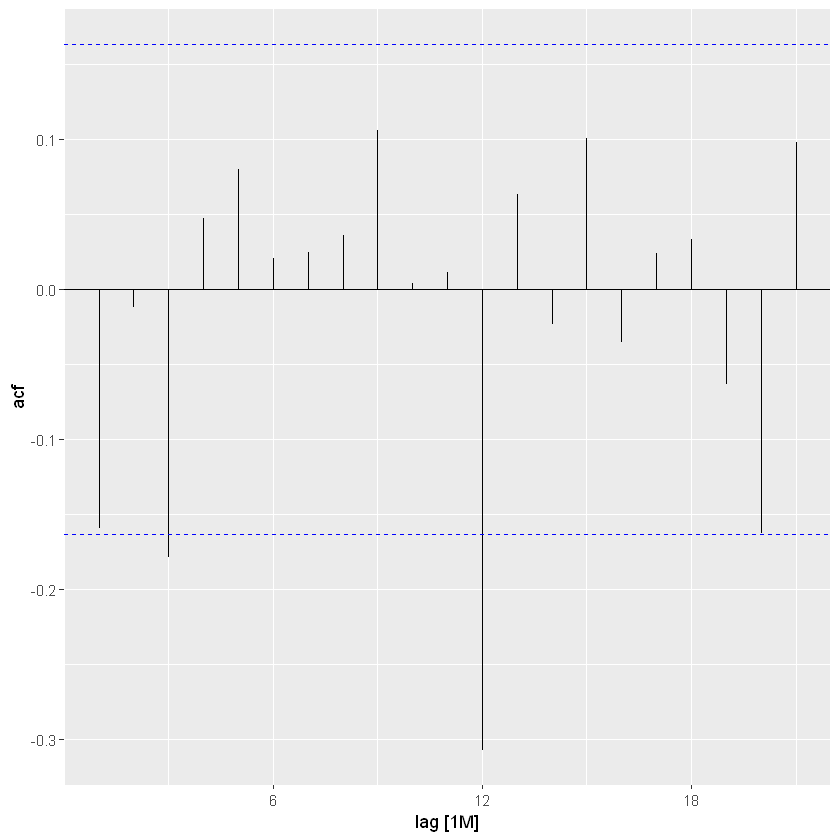

In [105]:
seasonal_adj %>% ACF(diff(season_adjust)) %>% autoplot()

- Future seasonal adjustments usually published in-advance and reran periodically  
- Show link to BLS (https://www.bls.gov/cpi/seasonal-adjustment/home.htm)